# Computing the energy of water on IBM

## Set experiment parameters

In [2]:
ibm_computer: str = "ibm_boston"
qubits = [24, 25, 26, 27, 28, 29, 30, 37, 38, 45, 46, 47, 48, 49]
nshots: int = 250_000  # "Base" number of shots. See how shots are set per circuit/group below.

len(qubits)

14

## Setup

In [3]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [4]:
service = qiskit_ibm_runtime.QiskitRuntimeService(name="qdc-2025")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [5]:
hamiltonian = of.jordan_wigner(
        of.get_fermion_operator(
    of.chem.MolecularData(filename="monomer_eqb.hdf5").get_molecular_hamiltonian()
    )
)
nqubits = of.utils.count_qubits(hamiltonian)
nterms  = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1620 term(s).


In [6]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [7]:
water_eqb_circuits = pickle.load(open("./water_eqb_circuits", "rb"))

for i, (error, circuit, layout) in enumerate(water_eqb_circuits):
    print("Error =", error)
    print("Circuit stats:", circuit.count_ops())
    # qasm3.dump(circuit, open(f"circuit_{i}_error_{error}", "w"))

Error = 0.037555931951644084
Circuit stats: OrderedDict([('sx', 31), ('rz', 25), ('cz', 15), ('x', 10), ('barrier', 1)])
Error = 0.03379578090144264
Circuit stats: OrderedDict([('sx', 62), ('rz', 50), ('cz', 30), ('x', 10), ('barrier', 2)])
Error = 0.030943222097420175
Circuit stats: OrderedDict([('sx', 112), ('rz', 81), ('cz', 55), ('x', 11), ('barrier', 3)])
Error = 0.027695213747492176
Circuit stats: OrderedDict([('sx', 171), ('rz', 115), ('cz', 82), ('x', 13), ('barrier', 4)])
Error = 0.02339403255849959
Circuit stats: OrderedDict([('sx', 241), ('rz', 149), ('cz', 117), ('x', 13), ('barrier', 5)])
Error = 0.01931645584224384
Circuit stats: OrderedDict([('sx', 299), ('rz', 171), ('cz', 144), ('x', 12), ('barrier', 6)])
Error = 0.01475382803189973
Circuit stats: OrderedDict([('sx', 367), ('rz', 208), ('cz', 179), ('x', 12), ('barrier', 7)])
Error = 0.008882504924585533
Circuit stats: OrderedDict([('sx', 413), ('rz', 225), ('cz', 201), ('x', 12), ('barrier', 8)])
Error = 0.00578208149

In [8]:
error, circuit, layout = water_eqb_circuits[5]
circuit.draw(fold=-1, idle_wires=False)

global phase: π/2
              ┌───┐                                                                                                                                                                                                                                                                                                                                            ░                                                                                                                                                                                                                                                                                                                                                                                                                                           ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ░                                                                                                                                                                                                                                                                                                                                                                                                                                   ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ 
 q_13 -> 6 ───┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [9]:
ops = list(circuit.count_ops().keys())


In [10]:
num1 = list(circuit.count_ops().values())

In [11]:
num2 = list(circuit.count_ops().values())

In [12]:
num3 = list(circuit.count_ops().values())

In [13]:
xs = np.array(range(len(ops)))
xs

array([0, 1, 2, 3, 4])

In [14]:
shift = 0.25
w = 0.2

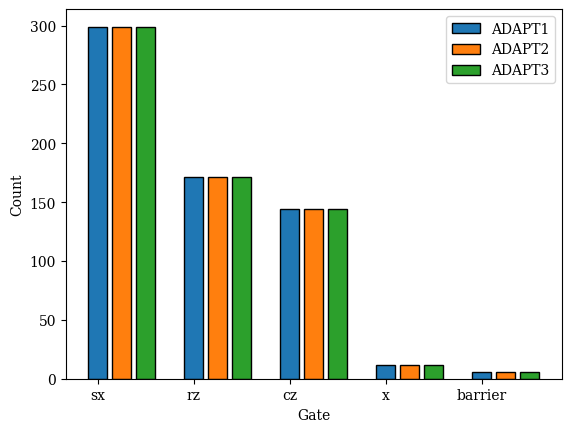

In [15]:
plt.bar(xs, num1, edgecolor="black", width=w, label="ADAPT1")
plt.bar(xs + shift, num2, edgecolor="black", width=w, label="ADAPT2")
plt.bar(xs + 2 * shift, num3, edgecolor="black", width=w, label="ADAPT3")
plt.xticks(xs, ops)
plt.xlabel("Gate")
plt.ylabel("Count")
plt.legend();
# plt.title("Ansatz 2");

In [16]:
order = [1, 9, 8, 0, 7, 12, 13, 5, 4, 6, 3, 2, 10, 11]
perm = {cirq.LineQubit(i): o for i, o in enumerate(order)}
perm

{cirq.LineQubit(0): 1,
 cirq.LineQubit(1): 9,
 cirq.LineQubit(2): 8,
 cirq.LineQubit(3): 0,
 cirq.LineQubit(4): 7,
 cirq.LineQubit(5): 12,
 cirq.LineQubit(6): 13,
 cirq.LineQubit(7): 5,
 cirq.LineQubit(8): 4,
 cirq.LineQubit(9): 6,
 cirq.LineQubit(10): 3,
 cirq.LineQubit(11): 2,
 cirq.LineQubit(12): 10,
 cirq.LineQubit(13): 11}

In [17]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)
base.draw(fold=-1, idle_wires=False)

global phase: π/2
          ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  q_6: ───┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [18]:
circuit_cirq = circuit_from_qasm(qasm2.dumps(base))
circuit_cirq

┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                ┌──────┐
q_6: ─────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

q_28: ────X───────────────────────────────────────────────────────────────────────────

In [19]:
psi = cirq.Simulator().simulate(circuit_cirq).final_state_vector

In [20]:
energy_exact = hamiltonian_cirq.expectation_from_state_vector(
    psi, perm
)
energy_exact

(-74.19454883753897+8.369251838832445e-18j)

## Preprocessing

### Compile the circuit

In [21]:
base = qiskit.transpile(
    base,
    optimization_level=3,
    # initial_layout=qubits,
    seed_transpiler=1,
)
print(base.count_ops())
base.draw(fold=-1, idle_wires=False)

OrderedDict([('cz', 142), ('sx', 136), ('u2', 70), ('u3', 42), ('x', 7), ('u1', 2)])


global phase: 1.5465
            ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  q_6: ─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            ├───┤                                                                                                                                                                                                                                                                                                                                                  

### Compress the Hamiltonian

In [22]:
# hamiltonian.compress(0.001)

### Compute exact energy for comparison

In [23]:
circuit_cirq = circuit_from_qasm(qasm2.dumps(base))
circuit_cirq

┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────────────────────────────────────────────────────────────────┐                                                                                                                                                              

In [24]:
psi = cirq.Simulator().simulate(circuit_cirq).final_state_vector

In [25]:
energy_exact = hamiltonian_cirq.expectation_from_state_vector(
    psi, {q: i for i, q in enumerate(hamiltonian_cirq.qubits)}
)
energy_exact

(-73.55058789480991+6.384944278234728e-16j)

In [26]:
circuit_qiskit = qiskit.QuantumCircuit.from_qasm_str(circuit_cirq.to_qasm())
circuit_qiskit.draw(fold=-1)

┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
 q_0: ───────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             ├───┤                                                                                                                                         

In [27]:
circuit_qiskit.save_statevector()
res = AerSimulator().run(circuit_qiskit).result()

In [28]:
psi_qiskit = res.data(circuit_qiskit)["statevector"].data

In [29]:
energy_exact_qiskit = hamiltonian_cirq.expectation_from_state_vector(
    psi_qiskit, {q: nqubits - i - 1 for i, q in enumerate(hamiltonian_cirq.qubits)}  # Note reversed qubit order between Cirq / Qiskit.
)
energy_exact_qiskit

(-73.55058784155472+6.6425958662865245e-21j)

In [30]:
assert np.isclose(energy_exact_qiskit, energy_exact)

### Group Hamiltonian

In [31]:
import kcommute

In [32]:
groups = kcommute.get_si_sets(hamiltonian, kcommute.compute_blocks(hamiltonian_cirq.qubits, k=nqubits))

In [33]:
groups_cirq = [of.qubit_operator_to_pauli_sum(sum(group)) for group in groups]

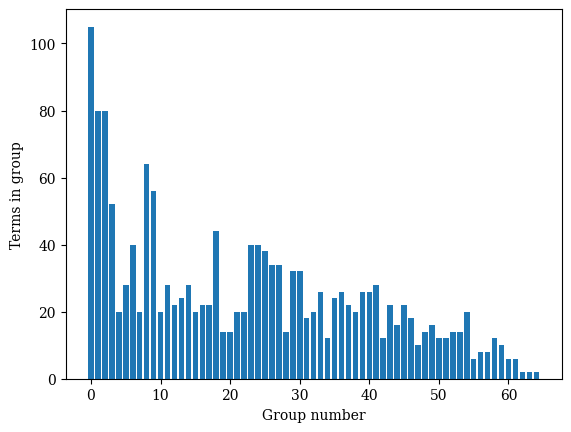

In [34]:
plt.bar(range(len(groups)), [len(group) for group in groups])
plt.xlabel("Group number")
plt.ylabel("Terms in group");

### Get measurement circuits

In [35]:
from diagonalize import diagonalize_pauli_strings

In [36]:
measurement_circuits = []
conjugated_paulis = []
for i, group in enumerate(groups_cirq):
    print(f"On group {i + 1} / {len(groups)}.", end="\r")
    meas_circuit, conjugated_strings = diagonalize_pauli_strings(group, cirq.LineQubit.range(nqubits))
    measurement_circuits.append(meas_circuit)
    conjugated_paulis.append(conjugated_strings)

On group 65 / 65.

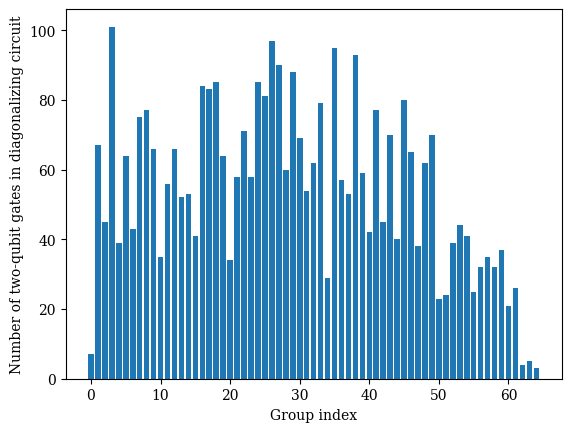

In [37]:
twoq_measurement_circuit_counts = [
    len([op for op in m.all_operations() if len(op.qubits) == 2])
    for m in measurement_circuits
]
plt.bar(range(len(twoq_measurement_circuit_counts)), twoq_measurement_circuit_counts)
plt.xlabel("Group index")
plt.ylabel("Number of two-qubit gates in diagonalizing circuit");

In [38]:
np.average(twoq_measurement_circuit_counts)

54.69230769230769

### Set the number of shots per group

In [39]:
weights = []
for g in groups_cirq:
    weight = 0.0
    for pauli in g:
        weight += np.abs(pauli.coefficient)
    weights.append(weight)

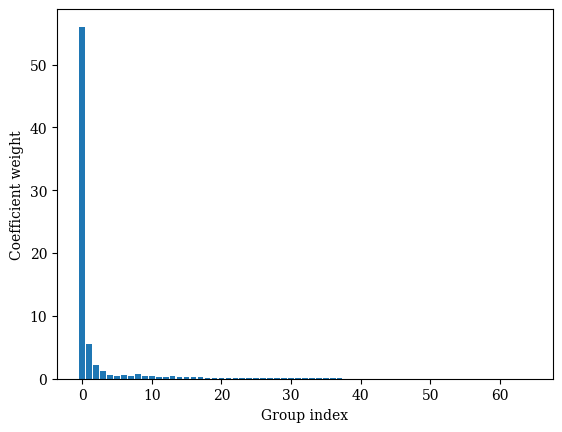

In [40]:
plt.bar(range(len(weights)), weights)
plt.xlabel("Group index")
plt.ylabel("Coefficient weight");

In [41]:
shots = [max(int(nshots * w / weights[0]), 1024) for w in weights]
sum(shots)

363030

#### Conversions

In [42]:
circuit_cirq = circuit_from_qasm(qasm2.dumps(base))

In [43]:
qmap = {qold: qnew for qold, qnew in zip(sorted(circuit_cirq.all_qubits()), cirq.LineQubit.range(nqubits))}
qmap

{cirq.NamedQubit('q_6'): cirq.LineQubit(0),
 cirq.NamedQubit('q_28'): cirq.LineQubit(1),
 cirq.NamedQubit('q_75'): cirq.LineQubit(2),
 cirq.NamedQubit('q_86'): cirq.LineQubit(3),
 cirq.NamedQubit('q_87'): cirq.LineQubit(4),
 cirq.NamedQubit('q_88'): cirq.LineQubit(5),
 cirq.NamedQubit('q_89'): cirq.LineQubit(6),
 cirq.NamedQubit('q_96'): cirq.LineQubit(7),
 cirq.NamedQubit('q_97'): cirq.LineQubit(8),
 cirq.NamedQubit('q_105'): cirq.LineQubit(9),
 cirq.NamedQubit('q_106'): cirq.LineQubit(10),
 cirq.NamedQubit('q_107'): cirq.LineQubit(11),
 cirq.NamedQubit('q_108'): cirq.LineQubit(12),
 cirq.NamedQubit('q_109'): cirq.LineQubit(13)}

In [44]:
circuit_cirq = circuit_cirq.transform_qubits(qmap)
circuit_cirq

┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ┌──┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌──────────────────────────────────────────────────────────────────┐                                                                                                                                                              

In [45]:
psi = cirq.Simulator().simulate(circuit_cirq).final_state_vector

In [46]:
qmap = {q: i for i, q in enumerate(hamiltonian_cirq.qubits)}

In [47]:
hamiltonian_cirq.expectation_from_state_vector(psi, qmap)

(-73.55058789480991+6.384944278234728e-16j)

#### Compute energy exactly after conversions + grouping

In [48]:
sum([len(group) for group in groups_cirq])

1619

In [49]:
len(list(hamiltonian_cirq))

1620

In [50]:
identity_term = list(hamiltonian_cirq)[0].coefficient
identity_term

(-46.85999302127529+0j)

In [51]:
expval = 0.0
for group in groups_cirq:
    expval += sum(group).expectation_from_state_vector(psi, qmap)
expval

(-26.690594873534536+6.384944278234732e-16j)

In [52]:
assert np.isclose(expval + identity_term, energy_exact)

In [53]:
to_run_cirq = [circuit_cirq + measurement_circuit for measurement_circuit in measurement_circuits]

In [54]:
psis = [cirq.Simulator().simulate(c).final_state_vector for c in to_run_cirq]

In [55]:
expval = 0.0
for pauli_list, psi in zip(conjugated_paulis, psis):
    expval += sum(pauli_list).expectation_from_state_vector(psi, qmap)
expval

(-26.690604298739515-3.368197886091526e-16j)

In [56]:
assert np.isclose(expval + identity_term, energy_exact)

### Compute energy exactly after conversions + grouping with sampling

In [57]:
qubits_cirq = cirq.LineQubit.range(nqubits)

In [58]:
to_run_cirq_measured = []
for c in to_run_cirq:
    c = c.copy()
    c.append(cirq.measure(qubits_cirq, key="z"))
    to_run_cirq_measured.append(c)

In [59]:
all_counts = []
for c in to_run_cirq_measured:
    counts = cirq.Simulator().run(c, repetitions=nshots).histogram(key="z")
    all_counts.append(
        Counter({np.binary_repr(bitstring, width=nqubits): count for bitstring, count in counts.items()})
    )

In [60]:
from expectation import compute_expectation

In [61]:
expval = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts):
    expval += compute_expectation(sum(conjugated_group), counts)
expval

(-26.690219989124895+1.4257407960867327e-11j)

In [62]:
expval + identity_term - energy_exact

(0.00037488440972310855+1.4256769466439503e-11j)

In [63]:
assert np.isclose(expval + identity_term, energy_exact, atol=2.0 / np.sqrt(nshots))

### With Qiskit + sampling

In [68]:
to_run = [qiskit.QuantumCircuit.from_qasm_str(c.to_qasm()) for c in to_run_cirq]

In [69]:
for c in to_run:
    c.measure_active()

In [70]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
)

In [86]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 3.9513
               ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ░       ┌─┐                                 
 q_0 -> 24 ────┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [79]:
BASE: int = 16

all_counts_aer = []
for i, c in enumerate(to_run):
    print(shots[i])
    job = AerSimulator().run(c, shots=shots[i])
    counts = Counter(
        {np.binary_repr(int(bitstring, BASE), nqubits): count for bitstring, count in job.result().data().get("counts").items()}
    )
    all_counts_aer.append(counts)

250000
24851
9742
5801
2834
2111
2684
2086
3068
1704
1778
1024
1220
1756
1049
1146
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024


In [80]:
expval = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_aer):
    expval += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval

(-26.681038202788752-8.287648786776486e-11j)

In [81]:
expval + identity_term - energy_exact

(0.009556670745865858-8.287712636219267e-11j)

In [82]:
assert np.isclose(expval + identity_term, energy_exact, atol=0.01)

## Run on hardware

In [83]:
pubs_to_run = [
    (c, None, shots[i]) for i, c in enumerate(to_run)
]

In [84]:
job = sampler.run(pubs_to_run)
# job = service.job("d499ugfnmdfs73ablva0")

In [87]:
all_counts_fez = []

In [88]:
res = job.result()

In [89]:
for r in res:
    all_counts_fez.append(r.data.meas.get_counts())

In [90]:
len(all_counts_fez)

65

In [91]:
expval_fez = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_fez):
    expval_fez += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_fez

(-25.99820136493826+1.740406245223063e-09j)

In [92]:
energy_fez = expval_fez + identity_term
energy_fez

(-72.85819438621354+1.740406245223063e-09j)

In [93]:
energy_exact

(-73.55058789480991+6.384944278234728e-16j)

In [94]:
error_raw = np.abs(np.real((energy_exact - energy_fez)))
error_raw

0.6923935085963677

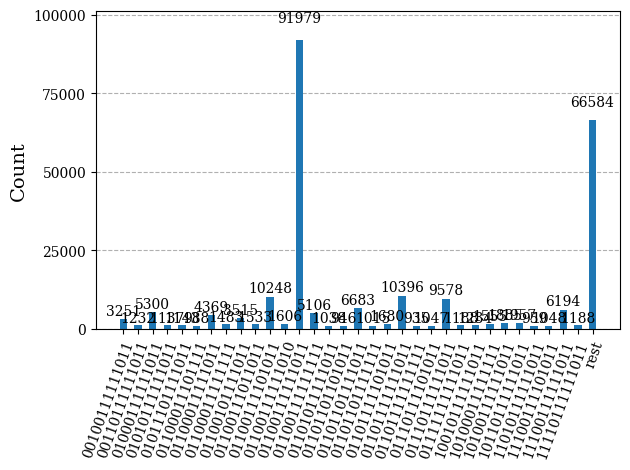

In [95]:
qiskit.visualization.plot_histogram(all_counts_fez[0], number_to_keep=32)

In [96]:
PARTICLE_NUMBER = 10

all_counts_fez_filtered = all_counts_fez.copy()

all_counts_fez_filtered[0] = {bitstring: count for bitstring, count in all_counts_fez[0].items() if bitstring.count("1") == PARTICLE_NUMBER}

sum(all_counts_fez_filtered[0].values()) / sum(all_counts_fez[0].values())

0.527088

In [97]:
expval_fez_filtered = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_fez_filtered):
    expval_fez_filtered += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_fez_filtered

(-26.555051146616304+1.740406245223063e-09j)

In [98]:
energy_fez_filtered = expval_fez_filtered + identity_term
energy_fez_filtered

(-73.4150441678916+1.740406245223063e-09j)

In [99]:
error_filtered = np.abs(np.real((energy_exact - energy_fez_filtered)))
error_filtered

0.13554372691831418

## Circuit stats

In [100]:
op_counts = Counter()
for c in to_run:
    for k, v in c.count_ops().items():
        op_counts[k] += v

In [101]:
ops = list(op_counts.keys())

In [102]:
op_counts = np.array(list(op_counts.values())) / len(to_run)

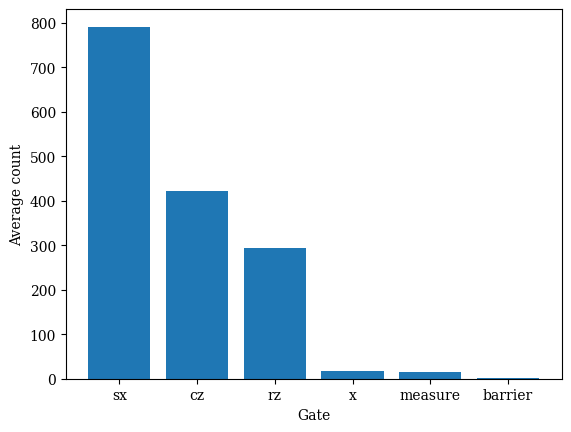

In [103]:
plt.bar(ops, op_counts)

plt.xlabel("Gate")
plt.ylabel("Average count");

## Save data

In [104]:
with open("all_circuits_boston.pkl", "wb") as file:
    pickle.dump(to_run, file)

with open("all_counts_boston.pkl", "wb") as file:
    pickle.dump(all_counts_fez, file)

with open("all_conjugated_paulis_boston.pkl", "wb") as file:
    pickle.dump(conjugated_paulis, file)

## Begin QEM

## With fractional gates

In [ ]:
job_fractional_gates = sampler_fractional_gates.run([to_run], shots=nshots)

In [ ]:
all_counts_frac = [result.data.measure.get_counts() for result in job_fractional_gates.result()]

In [ ]:
counts_frac = [get_counts_for(c, qubit1, qubit2) for c in all_counts_frac][0]
counts_frac

In [ ]:
exp_zz_frac = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_frac.items()
) / nshots
exp_zz_frac

## With dynamical decoupling

In [ ]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [262]:
# job_dd = sampler_dd.run(pubs_to_run)
job_dd = service.job("d49a9h2489vs73a17gd0")

In [263]:
all_counts_fez_dd = []

In [264]:
res_dd = job_dd.result()

In [265]:
for r in res_dd:
    all_counts_fez_dd.append(r.data.meas.get_counts())

In [266]:
len(all_counts_fez_dd)

65

In [267]:
expval_fez_dd = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_fez_dd):
    expval_fez_dd += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_fez_dd

(-24.839659257706774-1.7404062452230628e-09j)

In [268]:
energy_fez_dd = expval_fez_dd + identity_term
energy_fez_dd

(-71.69965227898206-1.7404062452230628e-09j)

In [269]:
error_dd = np.abs(np.real((energy_exact - energy_fez_dd)))
error_dd

1.8509356158278507

In [270]:
PARTICLE_NUMBER = 10

all_counts_fez_filtered_dd = all_counts_fez_dd.copy()

all_counts_fez_filtered_dd[0] = {bitstring: count for bitstring, count in all_counts_fez_dd[0].items() if bitstring.count("1") == PARTICLE_NUMBER}

sum(all_counts_fez_filtered_dd[0].values()) / sum(all_counts_fez_dd[0].values())

0.467256

In [271]:
expval_fez_dd_filtered = 0.0
for conjugated_group, counts in zip(conjugated_paulis, all_counts_fez_filtered_dd):
    expval_fez_dd_filtered += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_fez_dd_filtered

(-26.260035687012344-1.7404062452230628e-09j)

In [272]:
energy_fez_dd_filtered = expval_fez_dd_filtered + identity_term
energy_fez_dd_filtered

(-73.12002870828763-1.7404062452230628e-09j)

In [273]:
error_dd_filtered = np.abs(np.real(energy_exact - energy_fez_dd_filtered))
error_dd_filtered

0.43055918652227376

In [ ]:
with open("all_counts_fez_dd_sep25.pkl", "wb") as file:
    pickle.dump(all_counts, file)

## With readout error mitigation

In [ ]:
from qiskit_experiments.library import LocalReadoutError
from qiskit.result.distributions.quasi import QuasiDistribution 

from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis

In [ ]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

In [ ]:
correction_matrices = []
for i in range(len(qubits)):
    correction_matrices.append(mitigator.mitigation_matrix(qubits[i]))

counts_per_bit = []
for i in range(len(qubits)):
    counts_per_bit.append(get_counts_for(all_counts[0],i))

margdist_per_bit = []
for i in range(len(qubits)):
    margdist_per_bit.append(np.array([counts_per_bit[i].get("0"), counts_per_bit[i].get("1")]) / nshots)

corrected_margdist_per_bit = []
for i in range(len(qubits)):
    corrected_margdist_per_bit.append(mitigator.mitigation_matrix(qubits[i]) @ margdist_per_bit[i])

new_bits = []
for i in range(len(qubits)):
    new_bits.append(np.random.choice([0, 1], size=nshots, p=corrected_margdist_per_bit[i]))

corrected_bitstrings = ["".join(str(new_bits[i][j]) for i in range(len(qubits))) for j in range(nshots)]
corrected_counts = Counter(corrected_bitstrings)

In [ ]:
def apply_rem(
    counts: dict[str, int], 
    mitigator: "qiskit_experiments.LocalReadoutMitigator",
    *qubits) -> dict[str: int]:
    counts = get_counts_for(counts, *qubits)
    vec = np.zeros(2 ** len(qubits), dtype=float)
    for bitstring, count in counts.items():
        vec[int(bitstring, 2)] = count
    vec = vec / nshots
    assert np.allclose(vec.sum(), 1.0)

    mitigated_probs_quasi = mitigator.mitigation_matrix(qubits=qubits) @ vec
    mitigated_probs_quasi = QuasiDistribution({i: v for i, v in enumerate(mitigated_probs_quasi)})
    mitigated_counts = {
        bitstring: int(nshots * prob) for bitstring, prob in mitigated_probs_quasi.nearest_probability_distribution().binary_probabilities().items()
    }
    return mitigated_counts

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts]

In [ ]:
exp_zz_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_rem[0].items()
) / nshots
exp_zz_rem

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_dd]

In [ ]:
exp_zz_dd_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd_rem[0].items()
) / nshots
exp_zz_dd_rem

## With ZNE

In [202]:
from mitiq import zne

In [211]:
to_run = [qiskit.QuantumCircuit.from_qasm_str(c.to_qasm()) for c in to_run_cirq]

In [212]:
scale_factors = [2, 3]

In [217]:
to_run_scaled = [zne.scaling.fold_global(c, s) for s in scale_factors for c in to_run]

In [220]:
for c in to_run_scaled:
    c.measure_active()

In [221]:
to_run_scaled = qiskit.transpile(
    to_run_scaled,
    backend=computer,
    optimization_level=3,
)

In [223]:
pubs_to_run[0][0].count_ops()

OrderedDict([('sx', 284),
             ('rz', 151),
             ('cz', 140),
             ('measure', 14),
             ('x', 10),
             ('barrier', 1)])

In [226]:
to_run_scaled[66].count_ops()

OrderedDict([('sx', 1697),
             ('cz', 890),
             ('rz', 692),
             ('x', 15),
             ('measure', 14),
             ('barrier', 1)])

In [114]:
scaled_circuits_cirq = [zne.scaling.fold_global(circuit_cirq, scale_factor) for scale_factor in scale_factors]

In [115]:
to_run_cirq = [[scaled + measurement_circuit for scaled in scaled_circuits_cirq] for measurement_circuit in measurement_circuits]

In [116]:
to_run_zne = [[qiskit.QuantumCircuit.from_qasm_str(c.to_qasm()) for c in scaled_circuits] for scaled_circuits in to_run_cirq]

In [117]:
to_run_zne_flat = [c for scaled in to_run_zne for c in scaled]

In [118]:
for c in to_run_zne_flat:
    c.measure_active()

In [119]:
scaled_circuits = qiskit.transpile(
    to_run_zne_flat,
    backend=computer,
    # initial_layout=qubits,
    optimization_level=0,
)

In [120]:
pubs_to_run_zne = [
    (c, None, shots[i % len(groups)]) for i, c in enumerate(scaled_circuits)
]

In [128]:
pubs_to_run[0][0].count_ops()

OrderedDict([('sx', 284),
             ('rz', 151),
             ('cz', 140),
             ('measure', 14),
             ('x', 10),
             ('barrier', 1)])

In [135]:
job_zne = sampler.run(pubs_to_run_zne)
# job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [137]:
all_counts_zne = [result.data.meas.get_counts() for result in job_zne.result()]

In [138]:
scale_factor2_counts = all_counts_zne[:len(groups)]
scale_factor3_counts = all_counts_zne[len(groups):]

In [139]:
expval_scale2 = 0.0
for conjugated_group, counts in zip(conjugated_paulis, scale_factor2_counts):
    expval_scale2 += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_scale2

(-23.55842522805059-9.11641366545414e-10j)

In [141]:
energy_scale2 = identity_term + expval_scale2
energy_scale2

(-70.41841824932588-9.11641366545414e-10j)

In [142]:
expval_scale3 = 0.0
for conjugated_group, counts in zip(conjugated_paulis, scale_factor3_counts):
    expval_scale3 += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_scale3

(1.0018429689382933-1.9890357088263578e-09j)

In [143]:
energy_scale3 = identity_term + expval_scale3
energy_scale3

(-45.858150052336995-1.9890357088263578e-09j)

In [144]:
energy_fez

(-72.91152542581293+1.6575297573552982e-10j)

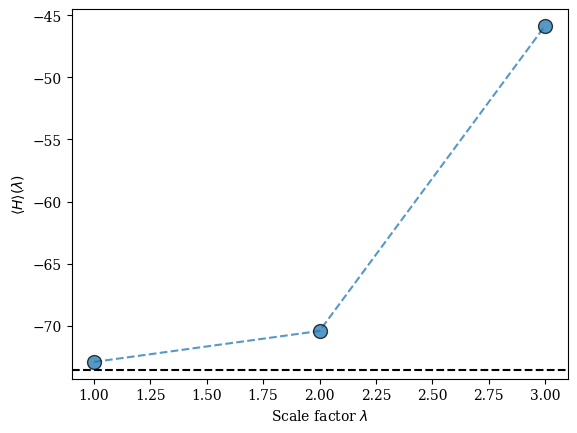

In [149]:
plt.plot([1] + scale_factors, [energy_fez, energy_scale2, energy_scale3], "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle H \rangle (\lambda) $");
plt.axhline(energy_exact.real, ls="--", color="black")

In [235]:
# Effective scale factors.
pubs_to_run[0][0].depth()

229

In [234]:
pubs_to_run_zne[0][0].depth()

2265

In [249]:
energy_zne = zne.inference.PolyFactory.extrapolate(
    [1, 5],
    [energy_fez, energy_scale2],
    order=1,
)
energy_zne

(-73.53480221993469+4.351015613057659e-10j)

In [250]:
error_zne = energy_zne - energy_exact
error_zne

(0.015785674875218092+4.3510092281133807e-10j)

### ZNE + Filtering

In [278]:
scale_factor2_counts_filtered = all_counts_zne[:len(groups)].copy()
scale_factor3_counts_filtered = all_counts_zne[len(groups):].copy()

In [279]:
PARTICLE_NUMBER = 10

scale_factor2_counts_filtered[0] = {bitstring: count for bitstring, count in scale_factor2_counts_filtered[0].items() if bitstring.count("1") == PARTICLE_NUMBER}
scale_factor3_counts_filtered[0] = {bitstring: count for bitstring, count in scale_factor3_counts_filtered[0].items() if bitstring.count("1") == PARTICLE_NUMBER}
sum(scale_factor3_counts_filtered[0].values()) / sum(all_counts_zne[:len(groups)][0].values())

0.05776

In [280]:
expval_scale2_filtered = 0.0
for conjugated_group, counts in zip(conjugated_paulis, scale_factor2_counts_filtered):
    expval_scale2_filtered += compute_expectation(sum(conjugated_group), counts, little_endian=False)
expval_scale2_filtered

(-25.15323308159705-9.11641366545414e-10j)

In [281]:
energy_scale2_filtered = expval_scale2_filtered + identity_term
energy_scale2_filtered

(-72.01322610287234-9.11641366545414e-10j)

In [284]:
energy_fez_filtered

(-73.47526162802791+1.6575297573552982e-10j)

In [285]:
energy_zne_filtered = zne.inference.PolyFactory.extrapolate(
    [1, 5],
    [energy_fez_filtered, energy_scale2_filtered],
    order=1,
)
energy_zne_filtered

(-73.84077050931677+4.351015613057659e-10j)

In [286]:
error_zne_filtered = np.abs(np.real(energy_exact - energy_zne_filtered))

## Plotting

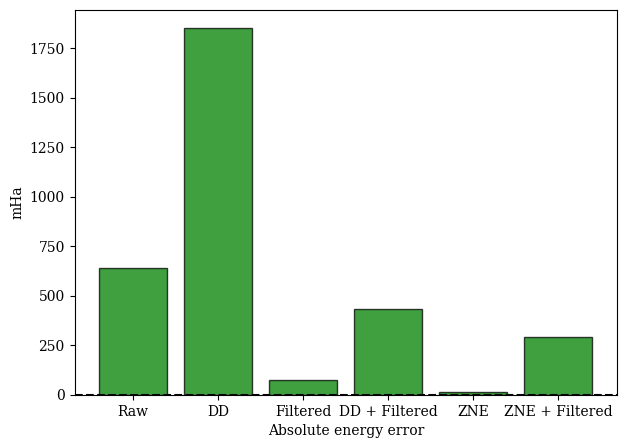

In [299]:
plt.figure(figsize=(7, 5))
plt.rcParams.update({"font.family": "serif"})
plt.bar(
    ["Raw", "DD", "Filtered", "DD + Filtered", "ZNE", "ZNE + Filtered"],
    np.array([error_raw, error_dd, error_filtered, error_dd_filtered, error_zne, error_zne_filtered]) * 1000,
    color="green",
    ec="black",
    alpha=0.75,
)
plt.axhline(1, ls="--", color="black")
# plt.ylim(0, 200)
plt.xlabel("Absolute energy error")
plt.ylabel("mHa");

## ZNE + REM

In [ ]:
counts_zne_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_zne]

In [ ]:
exp_zz_vals_zne_rem = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne_rem
]
exp_zz_vals_zne_rem

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne_rem = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals_zne_rem,
    order=2,
)
exp_zz_zne_rem

## With decoherence renormalization

In [ ]:
from typing import List, Optional


def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

In [ ]:
echo = get_echo_circuit(computer, qubits, depth=4, seed=1)

In [ ]:
echo.count_ops()

In [ ]:
job_echo = sampler.run([echo], shots=nshots)

In [ ]:
all_counts_echo = [result.data.measure.get_counts() for result in job_echo.result()]

In [ ]:
renormalization = 1.0 - all_counts_echo[0].get("0" * len(qubits), 0) / nshots
renormalization

In [ ]:
exp_zz_drn = exp_zz / renormalization
exp_zz_drn

## Plot results

In [ ]:
labels_vals = {
    "Ideal": exp_zz_ideal,
    "Hardware": exp_zz,
    "DD": exp_zz_dd,
    "REM": exp_zz_rem,
    "DD+REM": exp_zz_dd_rem,
    "ZNE": exp_zz_zne,
    "ZNE+REM": exp_zz_zne_rem,
}
colors = ["tab:green", "tab:red", "tab:grey", "tab:orange", "tab:pink", "tab:blue", "salmon"]
vals = list(labels_vals.values())
labels = list(labels_vals.keys())

plt.bar(range(len(vals)), vals, tick_label=labels, color=colors, edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
plt.savefig("hchain_qem_v4.pdf")